# Language Classification
This notebook contains the code for a CNN that classifies spoken language.

Used as reference:

https://github.com/pietz/language-recognition/blob/master/Language%20Classifier.ipynb

https://github.com/sergeyvilov/MCV-spoken-language-recognition/blob/master/audio_models.py

https://towardsdatascience.com/spoken-language-recognition-on-mozilla-common-voice-part-ii-models-b32780ea1ee4

https://towardsdatascience.com/spoken-language-recognition-on-mozilla-common-voice-part-i-3f5400bbbcd8

## Data Processing

In [3]:
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing import image
from tqdm import tqdm

In [4]:
langs = ["ar", "de", "en", "es", "fr", "hi", "it", "ja", "ru", "zh-CN"]
lang_nums = {
    "ar": 0,
    "de": 1,
    "en": 2,
    "es": 3,
    "fr": 4,
    "hi": 5,
    "it": 6,
    "ja": 7,
    "ru": 8,
    "zh-CN": 9
}

# langs = ["en", "zh-CN"]
# lang_nums = {
#     "en": 0,
#     "zh-CN": 1
# }

num_to_lang = {v: k for k, v in lang_nums.items()}

In [5]:
def load_images_from_path(path, label, num_images=1000):
    images = []
    labels = []

    count = 0
    files = os.listdir(path)
    files = np.random.choice(files, num_images, replace=False)
    for file in tqdm(files):
        # print(f"{count} - {file}")
        if count >= num_images:
            break
        try:
            img = image.img_to_array(image.load_img(os.path.join(path, file) , target_size=(192, 192, 3)).convert('L'))
            img = img.reshape((192, 192, 1))
            # from 255 to 0-1
            img = img / 255
            images.append(img)
            labels.append((label))
            count += 1
        except Exception as e:
            print(f"Error loading image: {file}")
            print(e)
        
    return images, labels

def show_images(images, label):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)
        ax.set_title(num_to_lang[labels[i]])  # Set the title for the subplot

ar


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:00<00:00, 2480.87it/s]


de


100%|██████████| 1000/1000 [00:00<00:00, 2179.57it/s]


en


100%|██████████| 1000/1000 [00:00<00:00, 2581.84it/s]


es


FileNotFoundError: [Errno 2] No such file or directory: 'data/spectrogram/es_train/'

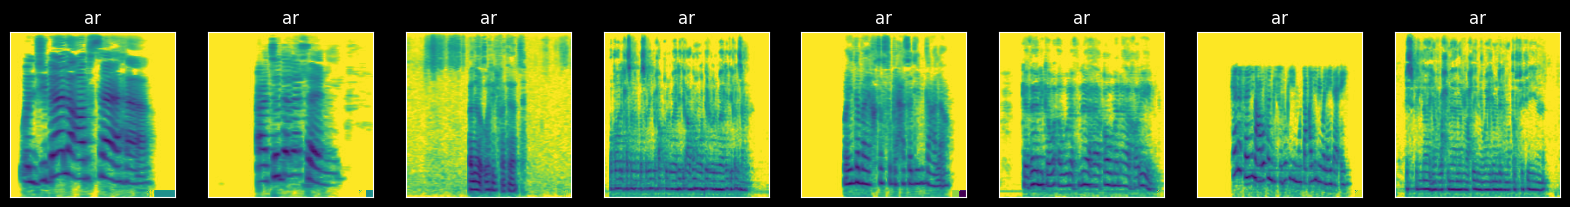

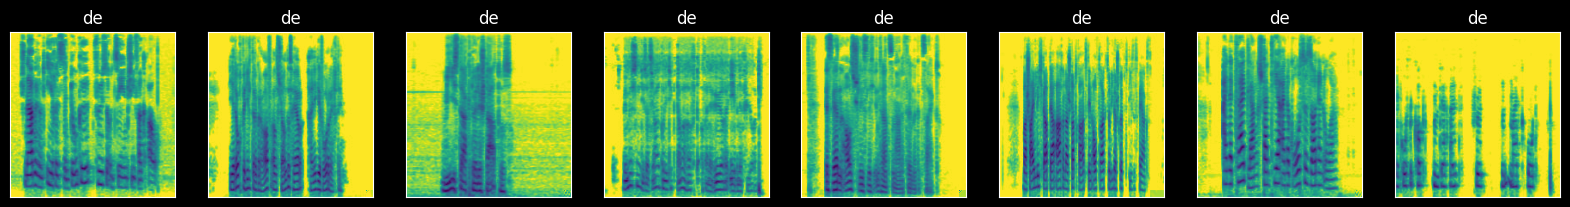

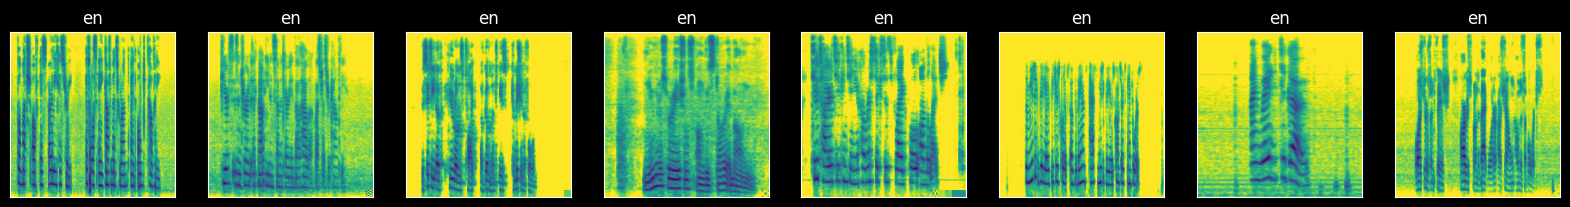

In [6]:
x = []
y = []
NUM_IMGS = 2000

for lang in langs:
    print(lang)
    path = f"data/spectrogram/{lang}_train/"
    images, labels = load_images_from_path(path, lang_nums[lang], num_images=NUM_IMGS)
    x += images
    y += labels
    show_images(images, labels)

In [487]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [488]:
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.3, random_state=0)

x_train_arr = np.array(x_train)
x_test_arr = np.array(x_test)

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

In [489]:
# truncate dataset for faster training:
x_train_arr = x_train_arr[:NUM_IMGS]
x_test_arr = x_test_arr[:NUM_IMGS]

y_train_encoded = y_train_encoded[:NUM_IMGS]
y_test_encoded = y_test_encoded[:NUM_IMGS]

print(x_train_arr.shape)
print(y_train_encoded.shape)

(1000, 192, 192, 1)
(1000, 2)


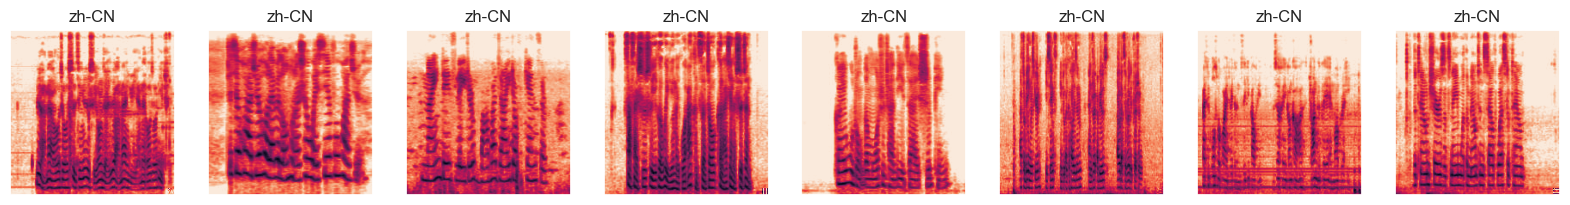

In [490]:
show_images(x_train_arr, y_train)

## Model

In [491]:
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input

In [492]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(192, 192, 1)))
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(2, 2))
# model.add(Conv2D(128, (3, 3), activation='relu'))
# model.add(MaxPooling2D(2, 2))
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dense(len(langs), activation='softmax'))
# model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# model.summary()

In [493]:

in_dim = (192, 192, 1)  # 192x192 grayscale images (1 color channel)
out_dim = len(langs) # number of langs

i = Input(shape=in_dim)
m = Conv2D(16, (3, 3), activation='elu', padding='same')(i)
m = MaxPooling2D()(m)
m = Conv2D(32, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(64, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(128, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Conv2D(256, (3, 3), activation='elu', padding='same')(m)
m = MaxPooling2D()(m)
m = Flatten()(m)
m = Dense(512, activation='elu')(m)
m = Dropout(0.5)(m)
o = Dense(out_dim, activation='softmax')(m)

model = Model(inputs=i, outputs=o)

# Change learning rate
opta = tf.keras.optimizers.Nadam(learning_rate=1e-3)
# optb = tf.keras.optimizers.Nadam(learning_rate=1e-4)

model.compile(loss='categorical_crossentropy', optimizer=opta, metrics=['accuracy'])
# model.compile(loss='categorical_crossentropy', optimizer=optb, metrics=['accuracy'])
# model.fit(x_tr, y_tr, epochs=3, verbose=1, validation_data=(x_va, y_va))

# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 192, 192, 1)]     0         
                                                                 
 conv2d_164 (Conv2D)         (None, 192, 192, 16)      160       
                                                                 
 max_pooling2d_164 (MaxPool  (None, 96, 96, 16)        0         
 ing2D)                                                          
                                                                 
 conv2d_165 (Conv2D)         (None, 96, 96, 32)        4640      
                                                                 
 max_pooling2d_165 (MaxPool  (None, 48, 48, 32)        0         
 ing2D)                                                          
                                                                 
 conv2d_166 (Conv2D)         (None, 48, 48, 64)        184

In [501]:
print(x_train_arr.shape)
print(y_train_encoded.shape)
print(x_test_arr.shape)
print(y_test_encoded.shape)
# print number per class
print(np.unique(y_train, return_counts=True))

(1000, 192, 192, 1)
(1000, 2)
(600, 192, 192, 1)
(600, 2)
(array([0, 1]), array([700, 700]))


## Train

In [509]:
hist = model.fit(x_train_arr, y_train_encoded, validation_data=(x_test_arr, y_test_encoded), batch_size=10, epochs=6, verbose=1)

Epoch 1/6
100/100 [==============================] - 8s 83ms/step - loss: 0.0676 - accuracy: 0.9740 - val_loss: 1.2180 - val_accuracy: 0.7300
Epoch 2/6
100/100 [==============================] - 8s 79ms/step - loss: 0.0868 - accuracy: 0.9740 - val_loss: 1.2925 - val_accuracy: 0.7450
Epoch 3/6
100/100 [==============================] - 8s 77ms/step - loss: 0.0958 - accuracy: 0.9630 - val_loss: 1.1651 - val_accuracy: 0.7383
Epoch 4/6
100/100 [==============================] - 8s 77ms/step - loss: 0.1349 - accuracy: 0.9490 - val_loss: 1.1075 - val_accuracy: 0.7733
Epoch 5/6
100/100 [==============================] - 8s 77ms/step - loss: 0.0967 - accuracy: 0.9670 - val_loss: 2.1556 - val_accuracy: 0.6567
Epoch 6/6
100/100 [==============================] - 8s 77ms/step - loss: 0.0939 - accuracy: 0.9660 - val_loss: 1.4949 - val_accuracy: 0.7517


[]

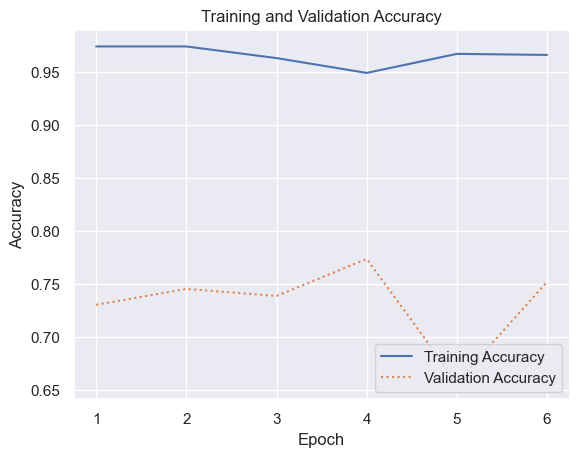

In [510]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [504]:
model.save('lang_classifier.keras')

In [505]:
# new_model = tf.keras.models.load_model('lang_classifier.keras')


In [506]:
# statically type model
model.test_on_batch(x_test_arr[250:1000], y_test_encoded[250:1000])

[0.9931880235671997, 0.7571428418159485]

In [507]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

19/19 [==============================] - 1s 47ms/step


Text(110.44999999999997, 0.5, 'Actual label')

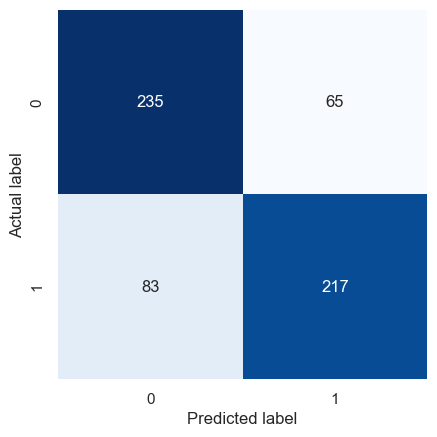

In [508]:
sns.set()

y_predicted = model.predict(x_test_arr)
mat = confusion_matrix(y_test_encoded.argmax(axis=1), y_predicted.argmax(axis=1))

sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues')

plt.xlabel('Predicted label')
plt.ylabel('Actual label')